In [17]:
import torch
import torchvision
import foolbox as fb 
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torchvision.models.resnet18(weights='DEFAULT').to(device)
model = model.eval()

In [18]:
preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
bounds = (0, 1)
fmodel = fb.PyTorchModel(model, bounds=bounds, preprocessing=preprocessing)
images, labels = fb.utils.samples(fmodel, dataset='imagenet', batchsize=16)

In [19]:
def fgsm(image, epsilon):
    image_grad = image.grad
    sign_data_grad = image_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [20]:

epsilons = np.linspace(0.0, 0.005, num=20)
robustness = {}
for epsilon in epsilons:
    correct = 0
    for image, target in zip(images,labels):
        image = images[0].to(device)
        target = labels[0].to(device)
        image.requires_grad = True

        output = model(torch.unsqueeze(image,0))
        first_pred = output.max(1, keepdim=True)[1]

        loss = F.nll_loss(output,torch.unsqueeze(target,0))
        model.zero_grad()
        loss.backward()

        perturbed_image = fgsm(image, epsilon)
        output= model(torch.unsqueeze(perturbed_image,0))
        last_pred = output.max(1,keepdim=True)[1]

        if first_pred == last_pred:
            correct += 1
        
    robustness[epsilon] = correct / 16.0
        
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0868288..1.0525501].


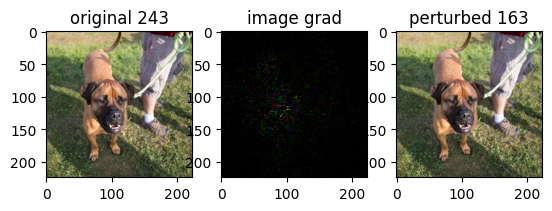

In [21]:
plt.subplot(1,3,1)
plt.title("original " + str(first_pred.item()))
plt.imshow(image.permute(1,2,0).to("cpu").detach().numpy())

plt.subplot(1,3,2)
plt.title("image grad")
image_grad = image.grad
plt.imshow(image_grad.permute(1,2,0).to("cpu").detach().numpy())

plt.subplot(1,3,3)
plt.title("perturbed " + str(last_pred.item()))
plt.imshow(perturbed_image.permute(1,2,0).to("cpu").detach().numpy())
plt.show()

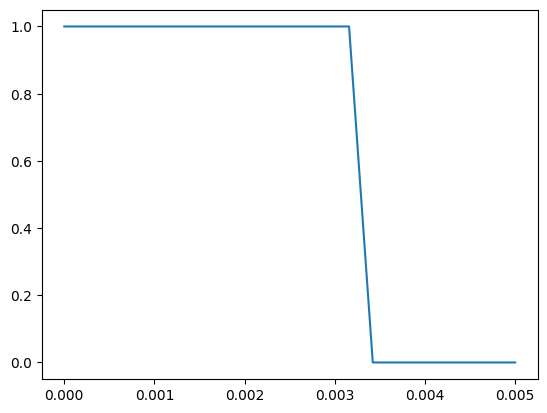

In [22]:
plt.plot(robustness.keys(),robustness.values())
plt.show()